# Global GDP Analysis Using Bayesian Multilevel Models
##### Ada Zhu (gz6xw), Adonis Lu (ayl3yq), Devan Visvalingam (dv5mx)


## Data Cleaning

In [169]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import arviz as az
plt.style.use('seaborn-darkgrid')

In [2]:
df = pd.read_csv("df_selected2.csv", index_col = 0)
df = df.dropna(subset=['GDP'])
df.head()

,country,date,GDP,Primary School Enrollment,Rural population percentage,CO2 emissions (kg per 2010 US$ of GDP)
2821,Afghanistan,2018,520.896603,NaN,74.505,NaN
2822,Afghanistan,2017,556.302139,0.68254,74.750,NaN
2823,Afghanistan,2016,547.228110,NaN,74.980,NaN
2824,Afghanistan,2015,578.466353,0.68839,75.197,NaN
2825,Afghanistan,2014,613.856333,0.69825,75.413,0.503629


In [3]:
#Split up Prior and Train 
p1 = df.loc[df['date'] <= 1980]
train =  df.loc[df['date'] > 1980]
train.head()

,country,date,GDP,Primary School Enrollment,Rural population percentage,CO2 emissions (kg per 2010 US$ of GDP)
2821,Afghanistan,2018,520.896603,NaN,74.505,NaN
2822,Afghanistan,2017,556.302139,0.68254,74.750,NaN
2823,Afghanistan,2016,547.228110,NaN,74.980,NaN
2824,Afghanistan,2015,578.466353,0.68839,75.197,NaN
2825,Afghanistan,2014,613.856333,0.69825,75.413,0.503629


In [4]:
countrylist = p1['country'].unique().tolist()
countrylist

['Afghanistan',
 'Algeria',
 'Argentina',
 'Australia',
 'Austria',
 'Bolivia',
 'Brazil',
 'Canada',
 'Chile',
 'China',
 'Denmark',
 'Fiji',
 'France',
 'Germany',
 'Haiti',
 'India',
 'Jamaica',
 'Japan',
 'Kenya',
 'Malaysia',
 'Morocco',
 'New Zealand',
 'Panama',
 'Peru',
 'South Africa',
 'Spain',
 'United Kingdom',
 'United States']

In [5]:
p1.reset_index(inplace=True)
del p1['index']
p1.head()

,country,date,GDP,Primary School Enrollment,Rural population percentage,CO2 emissions (kg per 2010 US$ of GDP)
0,Afghanistan,1980,272.655286,0.22998,84.005,NaN
1,Afghanistan,1979,275.738198,NaN,84.558,NaN
2,Afghanistan,1978,247.354106,0.20467,85.027,NaN
3,Afghanistan,1977,224.224797,0.19827,85.483,NaN
4,Afghanistan,1976,197.445508,0.18906,85.926,NaN


In [6]:
GDP1 = p1['GDP']

date1 = p1['date']

country1 = p1['country']
#--------
GDP2 = train['GDP']

date2 = train['date']

country2 = train['country']

#--------
GDP = df['GDP']

date = df['date']

country = df['country']

In [7]:
meanGDP = GDP.mean()
sdGDP = GDP.std()

In [8]:
unique_date1 = np.unique(date1)
length_date1 = len(unique_date1)
date_dict1 = dict(zip(unique_date1, range(length_date1)))

date_cleaned1 = date1.replace(date_dict1).values

In [9]:
date1 = date1.values
country1 = country1.values
GDP1 = GDP1.values

In [10]:
zGDP1 = ((GDP1 - meanGDP) / sdGDP) #prior standardized GDP

In [11]:
p1.head()

,country,date,GDP,Primary School Enrollment,Rural population percentage,CO2 emissions (kg per 2010 US$ of GDP)
0,Afghanistan,1980,272.655286,0.22998,84.005,NaN
1,Afghanistan,1979,275.738198,NaN,84.558,NaN
2,Afghanistan,1978,247.354106,0.20467,85.027,NaN
3,Afghanistan,1977,224.224797,0.19827,85.483,NaN
4,Afghanistan,1976,197.445508,0.18906,85.926,NaN


In [12]:
p1_df = p1.iloc[:, 0:3]

p1_df['GDP'] = zGDP1

In [13]:
p1_df.head()

,country,date,GDP
0,Afghanistan,1980,-0.646364
1,Afghanistan,1979,-0.646140
2,Afghanistan,1978,-0.648199
3,Afghanistan,1977,-0.649877
4,Afghanistan,1976,-0.651820


In [14]:
p1GDP_mean = p1_df['GDP'].mean()
p1GDP_std = p1_df['GDP'].std()

In [15]:
unique_country2 = np.unique(country2)
length_country2 = len(unique_country2)
country_dict2 = dict(zip(unique_country2, range(length_country2)))

country_cleaned2 = country2.replace(country_dict2).values

In [16]:
len(country_cleaned2)

1145

In [16]:
unique_date2 = np.unique(date2)
length_date2 = len(unique_date2)
date_dict2 = dict(zip(unique_date2, range(length_date2)))

date_cleaned2 = date2.replace(date_dict2).values

In [18]:
len(date_cleaned2)

1145

In [17]:
date2 = date2.values
country2 = country2.values
GDP2 = GDP2.values

In [18]:
zGDP2 = ((GDP2 - meanGDP) / sdGDP)

## Complete-Pooled Model

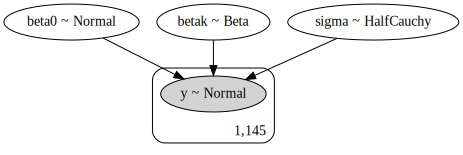

In [19]:
with Model() as pooled_model:
    beta0 = pm.Normal('beta0', mu=p1GDP_mean, sigma=p1GDP_std)
    betak = pm.Beta('betak', alpha=1, beta=1)
    
    sigma = HalfCauchy('sigma', 5)
    
    
    theta = beta0 + betak*date_cleaned2
    
    y = pm.Normal('y', mu=theta, sigma=sigma, observed=zGDP2)

model_to_graphviz(pooled_model)

In [20]:
with pooled_model:
    pooled_trace = sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betak, beta0]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:13<00:00, 3361.66draws/s]


(<Figure size 432x417.6 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2c6c9f98>],
       dtype=object))

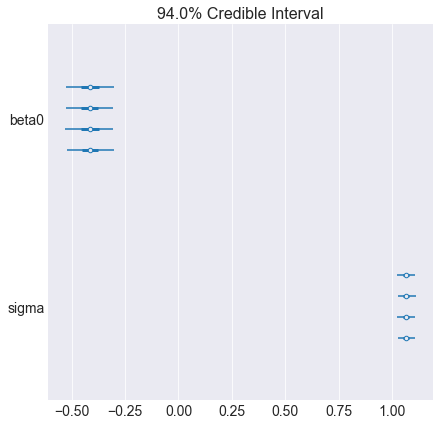

In [48]:
pm.forestplot(pooled_trace, var_names=['beta0', 'sigma'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2192c940>,
      dtype=object)

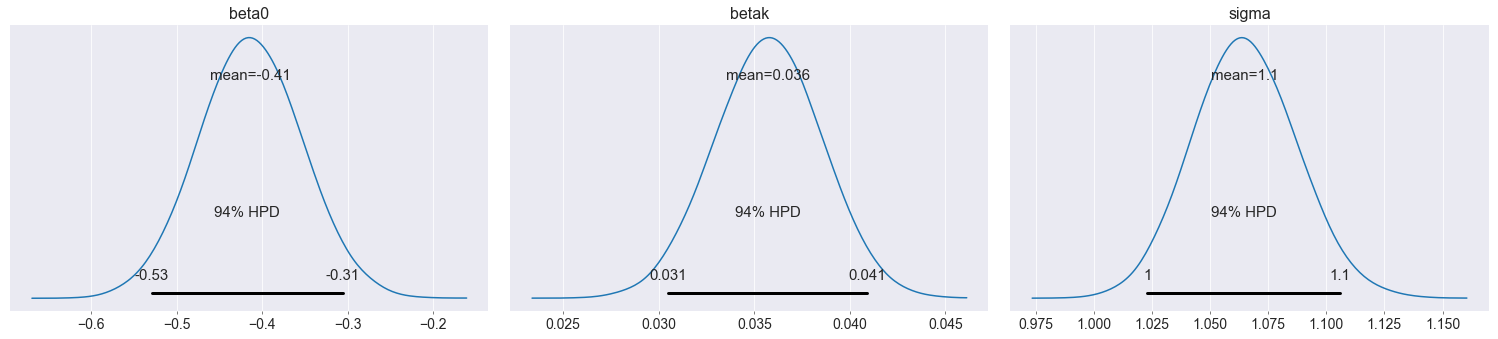

In [24]:
pm.plot_posterior(pooled_trace)

In [24]:
pooled_sum = pm.summary(pooled_trace)
pooled_sum

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta0,-0.414210,0.059345,0.000386,-0.527481,-0.295861,22362.827535,0.999995
betak,0.035734,0.002764,0.000018,0.030356,0.041153,22336.640172,1.000010
sigma,1.065262,0.022097,0.000141,1.022756,1.109539,25385.170142,1.000052


In [156]:
b0 = pooled_trace['beta0'].mean(axis=0)
bk = pooled_trace['betak'].mean(axis=0)

#### Complete-pooled model plot with credible interval bars

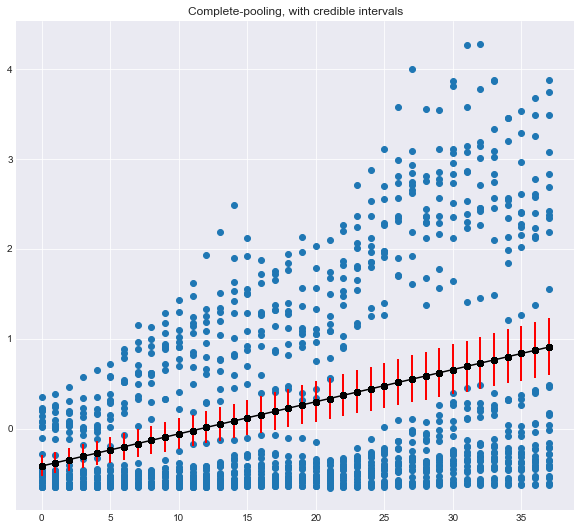

In [157]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(10, 9))

ax.scatter(date_cleaned2, zGDP2)

y_hat = b0 + bk*date_cleaned2
hpd_L = (pooled_sum.loc['beta0', 'hpd_2.5'] + 
        pooled_sum.loc['betak', 'hpd_2.5']*date_cleaned2)

hpd_U = (pooled_sum.loc['beta0', 'hpd_97.5'] + 
         pooled_sum.loc['betak', 'hpd_97.5']*date_cleaned2)



lower_error = y_hat - hpd_L
upper_error = hpd_U - y_hat
error_bar = [lower_error, upper_error]

ax.errorbar(date_cleaned2, y_hat, yerr=error_bar, 
            fmt='-o', ecolor='r', color='0')
ax.set_title('Complete-pooling, with credible intervals')


plt.show()

#fig.savefig("Pooled.png",bbox_inches='tight')



## Unpooled Model

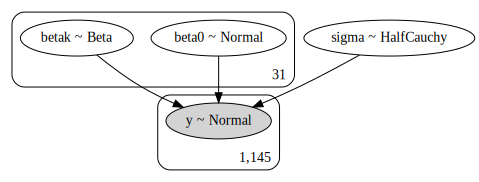

In [50]:
with Model() as unpooled_model:
    
    beta0 = pm.Normal('beta0', mu = p1GDP_mean, sigma = p1GDP_std, shape=length_country2)
    betak = pm.Beta('betak', alpha=1, beta=1, shape=length_country2)
    sigma = HalfCauchy('sigma', 5)
    
    theta = beta0[country_cleaned2] + betak[country_cleaned2]*date_cleaned2
    
    y = Normal('y', mu=theta, sigma=sigma, observed=zGDP2)
    
model_to_graphviz(unpooled_model)

In [51]:
with unpooled_model:
    unpooled_trace = sample(10000, cores = 4,nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betak, beta0]
Sampling 4 chains: 100%|██████████| 42000/42000 [01:39<00:00, 423.66draws/s]


(<Figure size 432x1180.8 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ef0c240>],
       dtype=object))

<Figure size 432x1008 with 0 Axes>

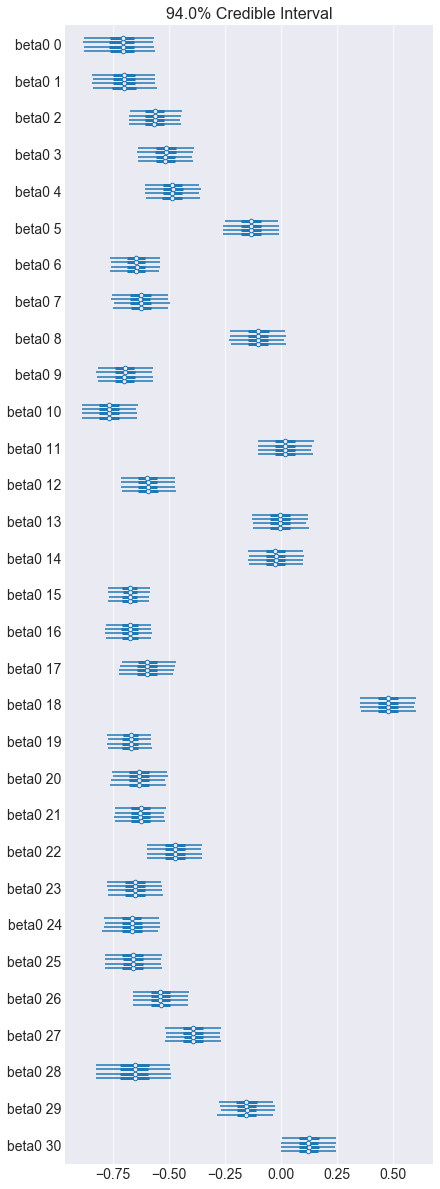

In [53]:
plt.figure(figsize=(6,14))
pm.forestplot(unpooled_trace, var_names=['beta0'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c27543ba8>,
      dtype=object)

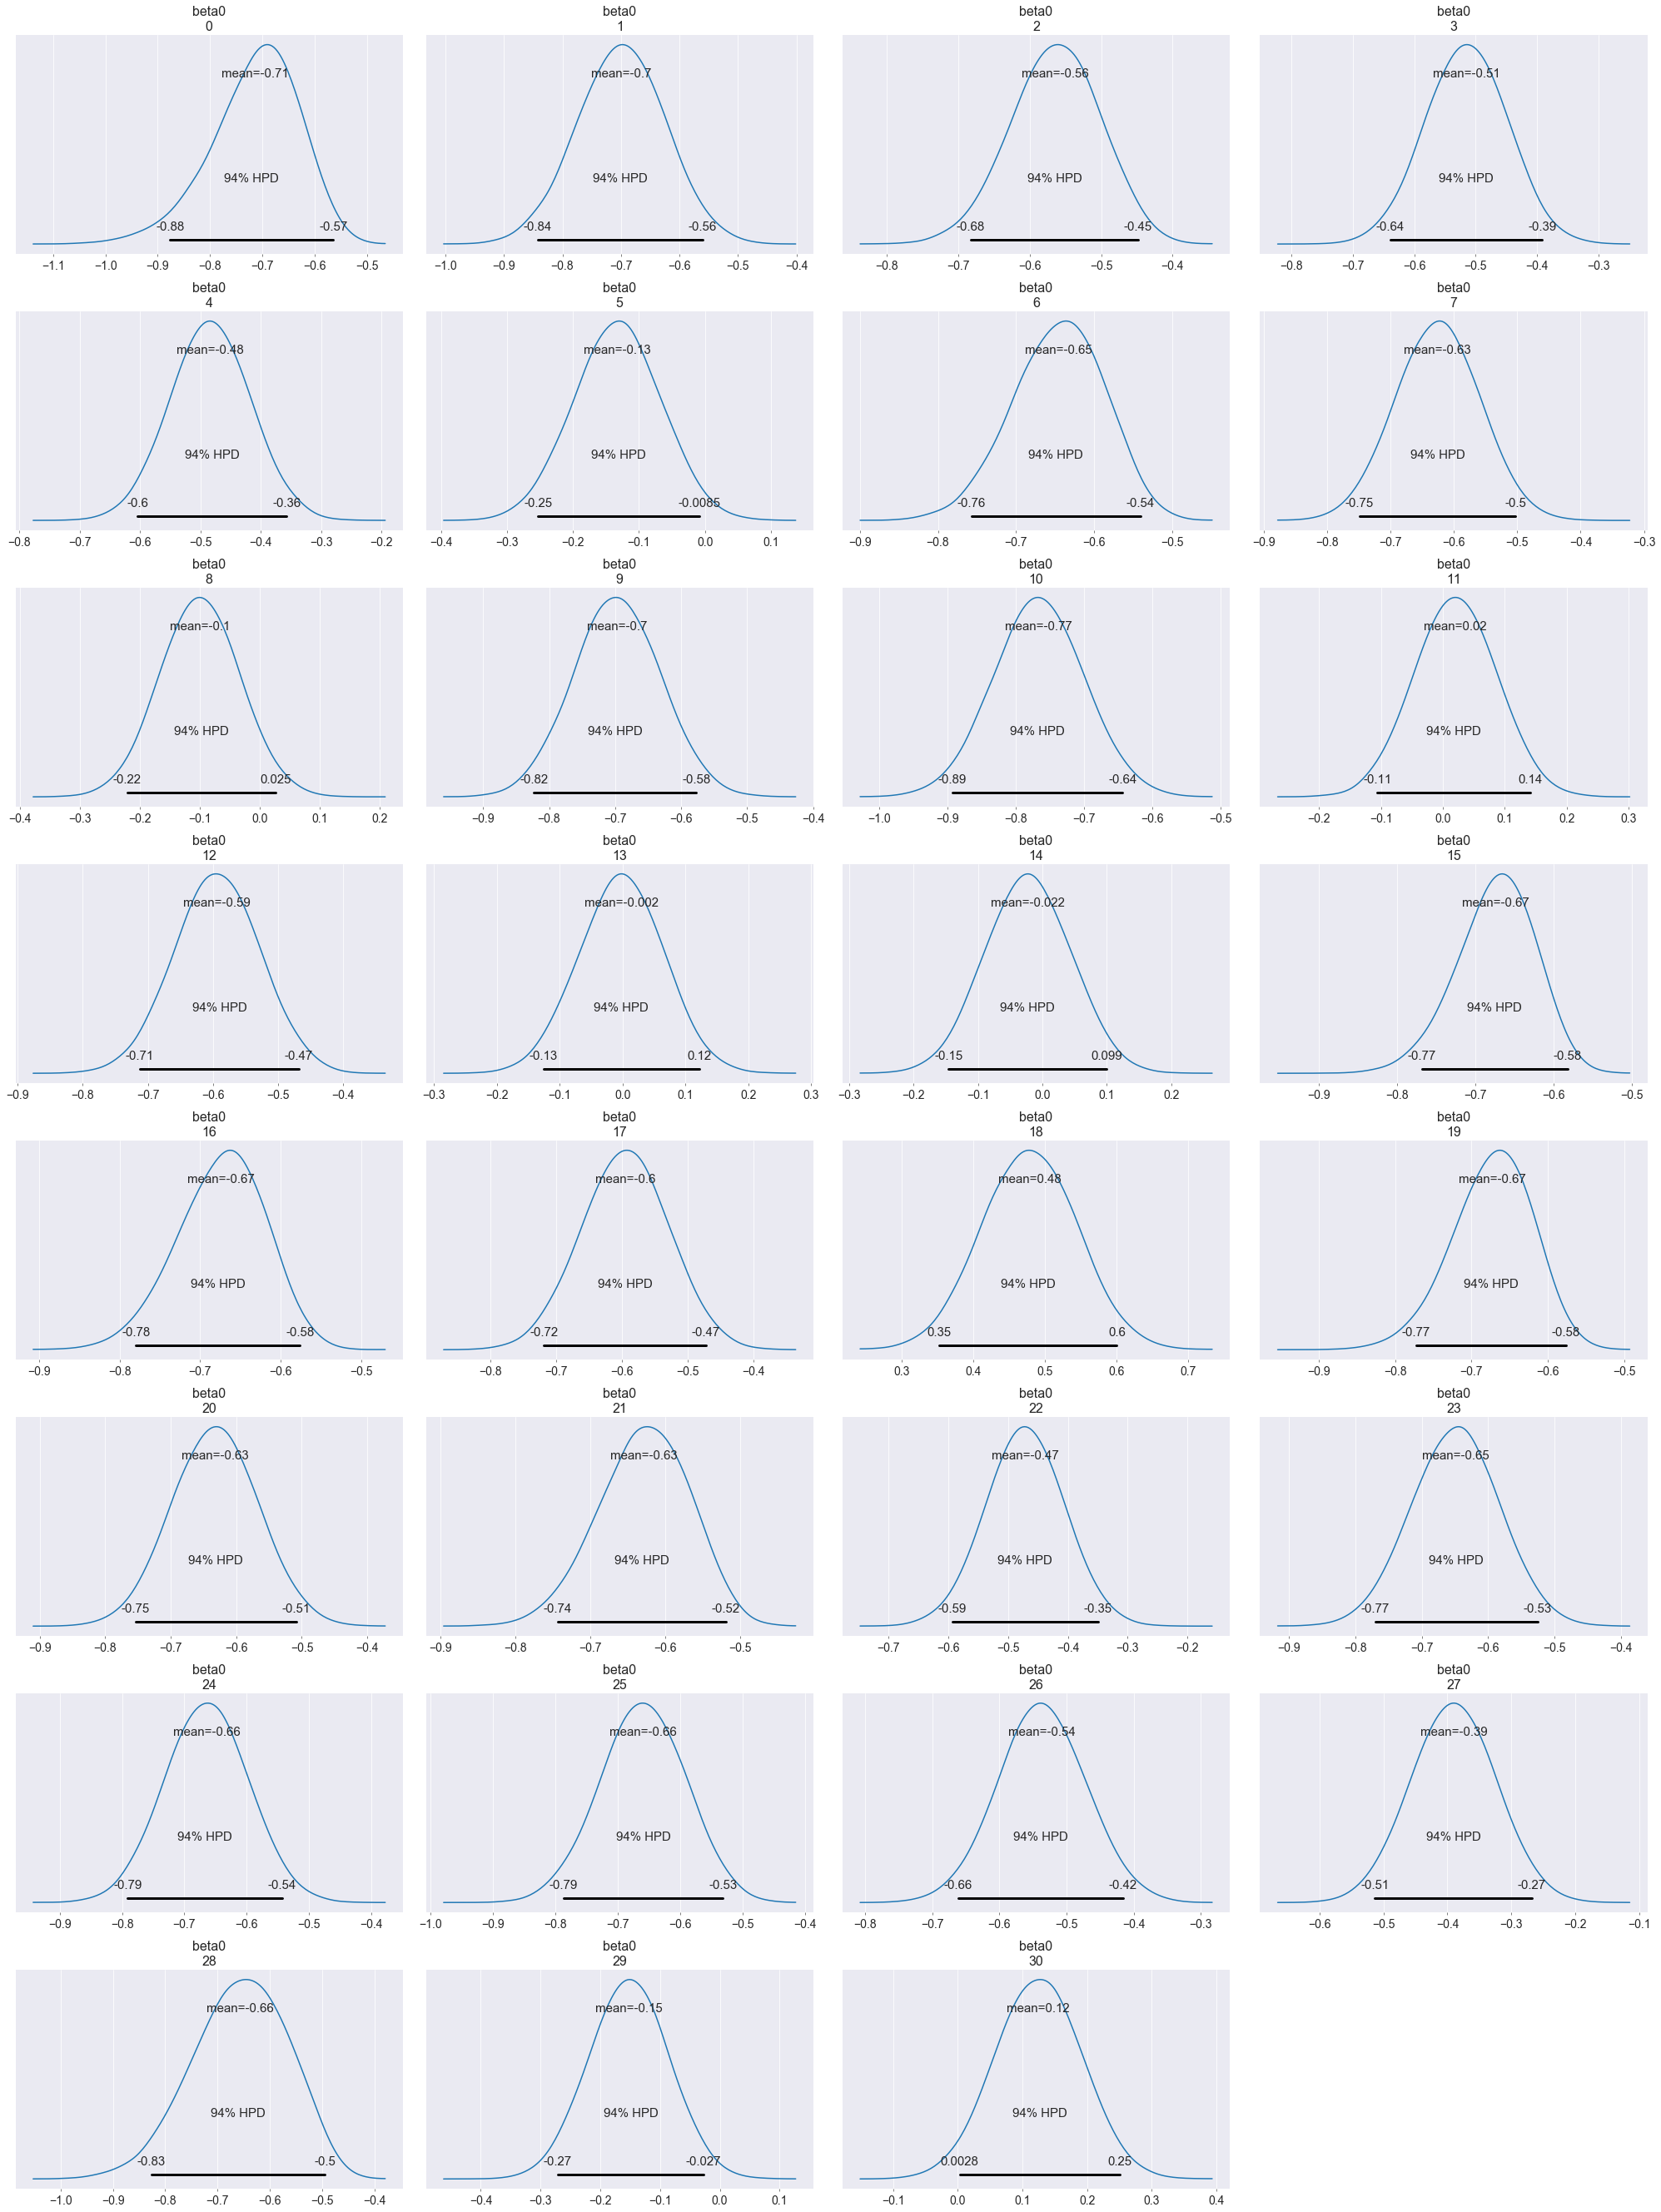

In [31]:
pm.plot_posterior(unpooled_trace, var_names=['beta0'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c266135c0>,
      dtype=object)

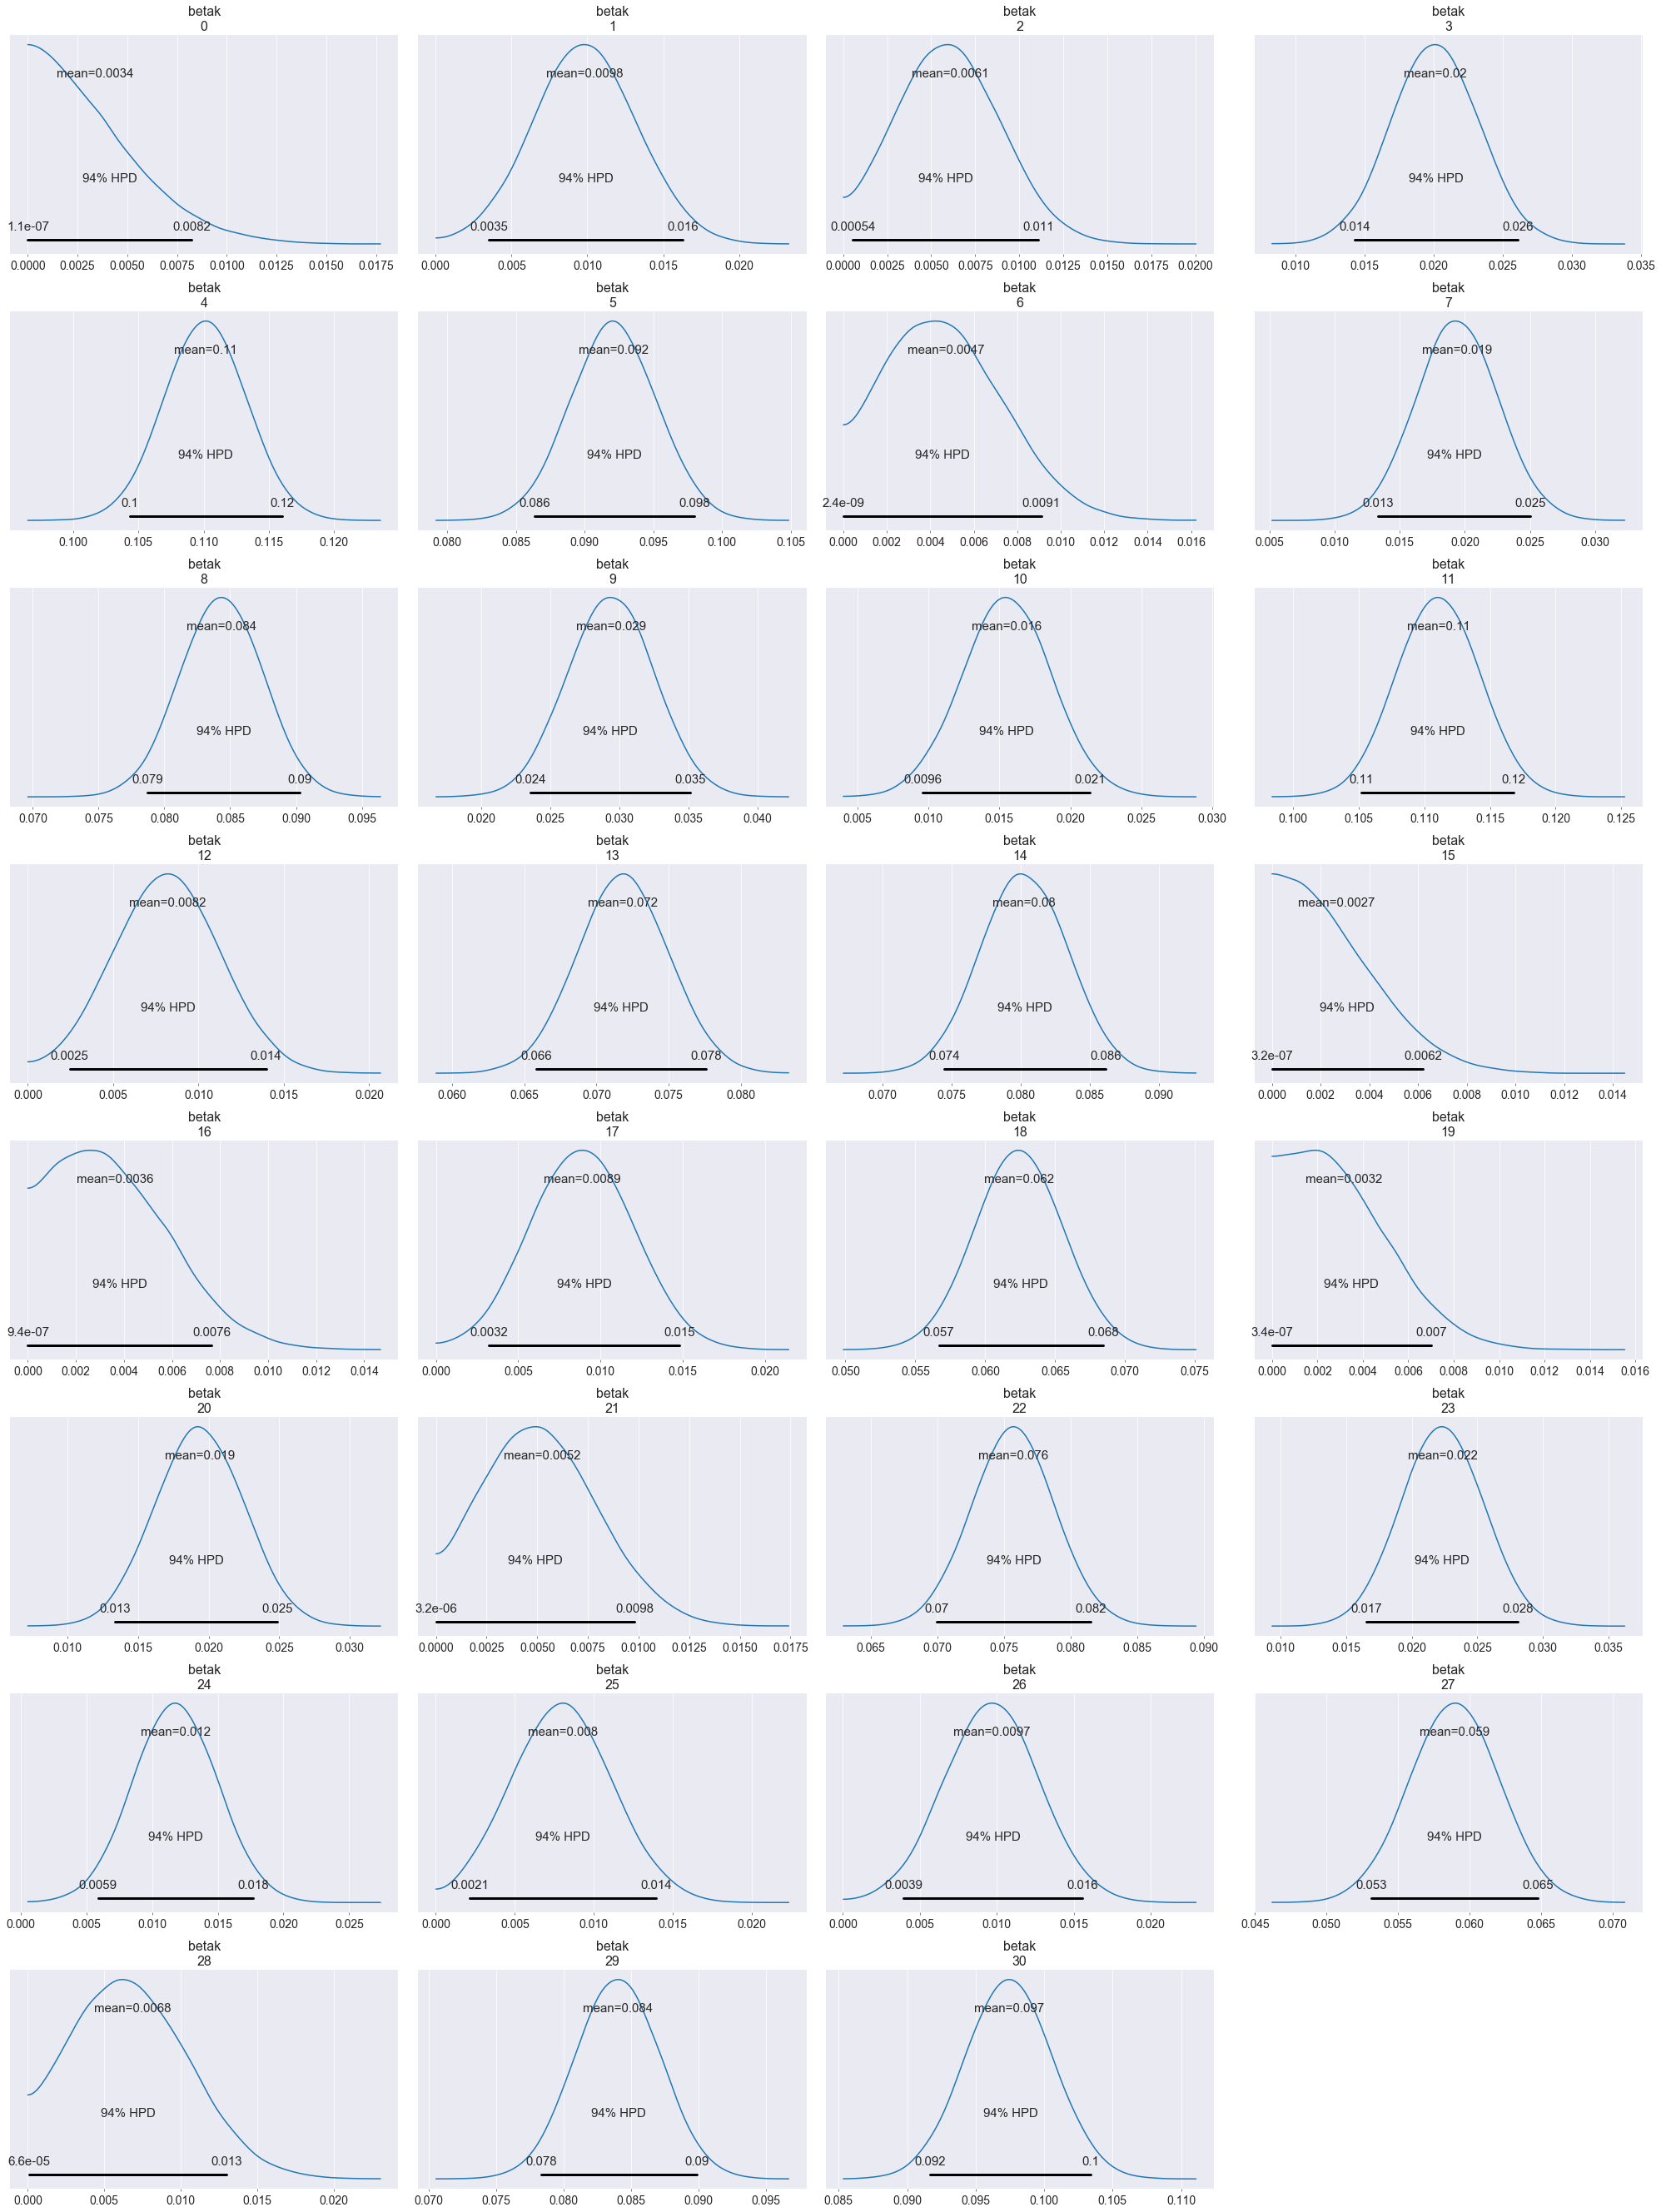

In [32]:
pm.plot_posterior(unpooled_trace, var_names=['betak'])

In [119]:
unpooled_sum = pm.summary(unpooled_trace)
unpooled_sum.head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta0__0,-0.713823,0.084456,0.000366,-0.886669,-0.559578,52228.374960,0.999994
beta0__1,-0.699623,0.075177,0.000306,-0.847642,-0.553200,52363.066700,0.999957
beta0__2,-0.564019,0.062010,0.000260,-0.685738,-0.445707,52248.731058,0.999962
beta0__3,-0.514191,0.065274,0.000245,-0.644864,-0.389112,71906.012538,0.999977
beta0__4,-0.482833,0.065304,0.000236,-0.610055,-0.354723,72868.583779,0.999982


In [158]:
b0 = unpooled_trace['beta0'].mean(axis=0)
bk = unpooled_trace['betak'].mean(axis=0)


#### Unpooled model plot with credible intervals against complete pooling

/Users/dvisvalingam/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


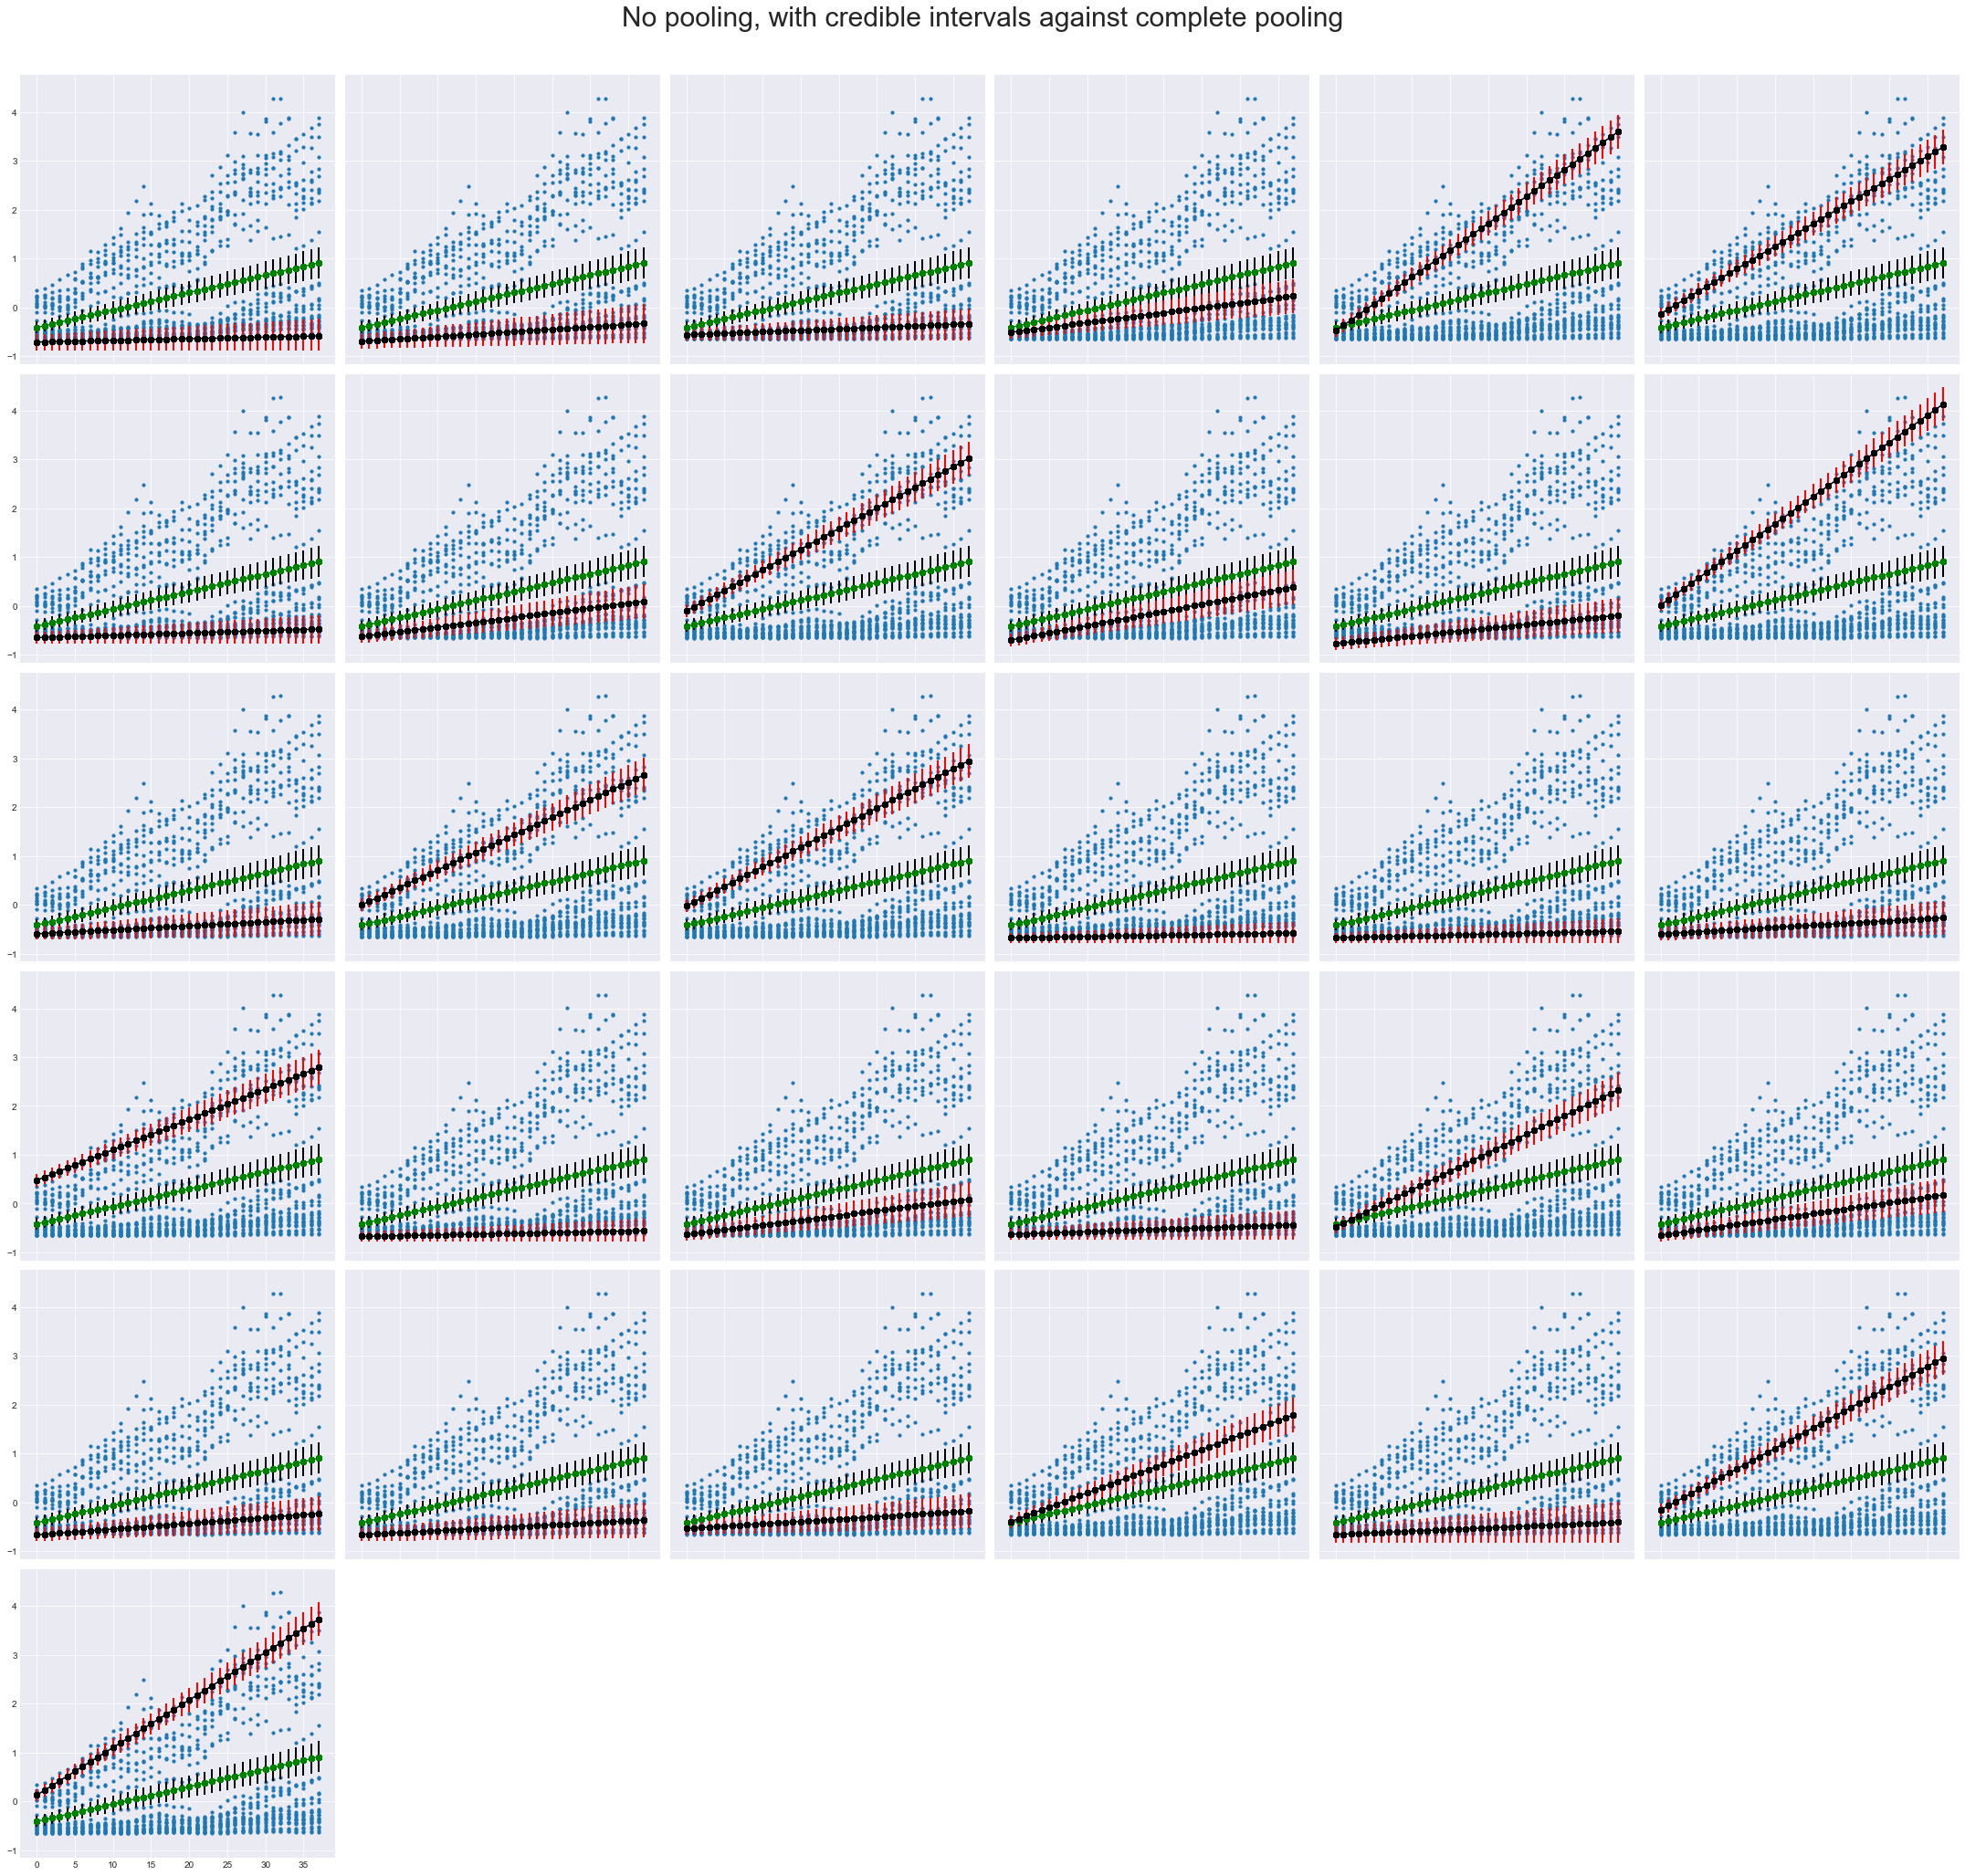

In [159]:
fig, ax = plt.subplots(nrows=6, ncols=6, sharex=True,
                      sharey=True, constrained_layout=True,
                      figsize=(30, 30))


global_b0 = pooled_trace['beta0'].mean(axis=0)
global_bk = pooled_trace['betak'].mean(axis=0)


global_y_hat = global_b0 + global_bk*date_cleaned2
global_hpd_L = (pooled_sum.loc['beta0', 'hpd_2.5'] + 
        pooled_sum.loc['betak', 'hpd_2.5']*date_cleaned2)

global_hpd_U = (pooled_sum.loc['beta0', 'hpd_97.5'] + 
         pooled_sum.loc['betak', 'hpd_97.5']*date_cleaned2)



global_lower_error = global_y_hat - global_hpd_L
global_upper_error = global_hpd_U - global_y_hat
global_error_bar = [global_lower_error, global_upper_error]

i = 0

for j in range(6):
    for k in range(6):
        if i <= 30:
            
            ax[j, k].scatter(date_cleaned2, zGDP2, s=10)
            
            ax[j, k].errorbar(date_cleaned2, global_y_hat, yerr=global_error_bar, 
                              fmt='-o', ecolor='0', color='g')
            y_hat = b0[i] + bk[i]*date_cleaned2
            hpd_L = unpooled_sum.iloc[i, 3] + unpooled_sum.iloc[i+31, 3]*date_cleaned2
            hpd_U = unpooled_sum.iloc[i, 4] + unpooled_sum.iloc[i+31, 4]*date_cleaned2

            lower_error = y_hat - hpd_L
            upper_error = hpd_U - y_hat

            error_bar = [lower_error, upper_error]

            ax[j,k].errorbar(date_cleaned2, y_hat, yerr=error_bar, 
                           fmt='-o', ecolor='r', color='0')

        i = i + 1
    

fig.delaxes(ax[5,1])
fig.delaxes(ax[5,2])
fig.delaxes(ax[5,3])
fig.delaxes(ax[5,4])
fig.delaxes(ax[5,5])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle('No pooling, with credible intervals against complete pooling', size=30)


plt.show()

#fig.savefig("Unpooled.png",bbox_inches='tight')
    

## Hierarchical Model

In [134]:
df.reset_index(inplace=True)
del df['index']
df.head()

,country,date,GDP,Primary School Enrollment,Rural population percentage,CO2 emissions (kg per 2010 US$ of GDP)
0,Afghanistan,2018,520.896603,NaN,74.505,NaN
1,Afghanistan,2017,556.302139,0.68254,74.750,NaN
2,Afghanistan,2016,547.228110,NaN,74.980,NaN
3,Afghanistan,2015,578.466353,0.68839,75.197,NaN
4,Afghanistan,2014,613.856333,0.69825,75.413,0.503629


In [135]:
d1 = pd.DataFrame()
prior = pd.DataFrame() #not really the prior
countrylist = df['country'].unique().tolist()
#missing_country = ['Albania', 'Argentina', 'Canada', 'Germany', 'Samoa', 'Tuvalu']

#for every country, grab the earliest data for each of the indicators
for i in range(len(df)-1):
    if (df['country'][i] in countrylist):        
    
        d1 = df.loc[df['country'] == df['country'][i]].sort_values(by = ['date'])

        val_GDP = d1.loc[~d1['GDP'].isnull()].iloc[0].iloc[2] #earliest GDP value recorded

        #val_school = d1.loc[~d1['Primary School Enrollment'].isnull()].iloc[0].iloc[4] #earliest GDP value recorded

        #val_rural = d1.loc[~d1['Rural population percentage'].isnull()].iloc[0].iloc[5] #earliest GDP value recorded

        #val_co2 = d1.loc[~d1['CO2 emissions (kg per 2010 US$ of GDP)'].isnull()].iloc[0].iloc[6] #earliest GDP value recorded

        #val_GDP = d1[(~d1['GDP'].isnull())  & (~d1['Primary School Enrollment'].isnull())  &(~d1['Rural population percentage'].isnull())&(~d1['CO2 emissions (kg per 2010 US$ of GDP)'].isnull())].iloc[0] #earliest GDP value recorded

        
        list1 = [df['country'][i], val_GDP]        
        df1 = pd.DataFrame([list1]) 

        prior = prior.append(df1)

        countrylist.remove(df['country'][i])

prior.columns = ['country', 'GDP']


In [136]:
d1.loc[~d1['GDP'].isnull()].iloc[0]

country                                   United States
date                                               1960
GDP                                             3007.12
Primary School Enrollment                           NaN
Rural population percentage                      30.004
CO2 emissions (kg per 2010 US$ of GDP)         0.911639
Name: 1719, dtype: object

In [125]:
prior.head()

,country,GDP
0,Afghanistan,59.773194
0,Albania,639.484736
0,Algeria,246.308763
0,Argentina,1155.890170
0,Australia,1807.785710


In [137]:
prior.reset_index(inplace=True)
del prior['index']

In [138]:
base1 = prior.sort_values(by = ['GDP'])
#country quartile list
g4 = base1.iloc[0:8, :]['country'].values #lowest GDP per capita
g3 = base1.iloc[8:16, :]['country'].values
g2 = base1.iloc[16:24, :]['country'].values
g1 = base1.iloc[24:32, :]['country'].values

In [139]:
train.reset_index(inplace=True)
del train['index']

In [141]:
train['Quartile Group'] = 4
train.head()

/Users/dvisvalingam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,country,date,GDP,Primary School Enrollment,Rural population percentage,CO2 emissions (kg per 2010 US$ of GDP),Quartile Group
0,Afghanistan,2018,520.896603,NaN,74.505,NaN,4
1,Afghanistan,2017,556.302139,0.68254,74.750,NaN,4
2,Afghanistan,2016,547.228110,NaN,74.980,NaN,4
3,Afghanistan,2015,578.466353,0.68839,75.197,NaN,4
4,Afghanistan,2014,613.856333,0.69825,75.413,0.503629,4


In [142]:
#Assign quartile groups to each country
for i in range(len(train)-1):
    if (train['country'][i] in g3):        
        train.iloc[i, 6] = 3
        
    elif (train['country'][i] in g2): 
        train.iloc[i, 6] = 2

    elif (train['country'][i] in g1):  
        train.iloc[i, 6] = 1

/Users/dvisvalingam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [164]:
train.columns

Index(['country', 'date', 'GDP', 'Primary School Enrollment',
       'Rural population percentage', 'CO2 emissions (kg per 2010 US$ of GDP)',
       'Quartile Group'],
      dtype='object')

In [167]:
(len(train[train['Quartile Group'] == 1]), len(train[train['Quartile Group'] == 2]),
 len(train[train['Quartile Group'] == 3]), len(train[train['Quartile Group'] == 4]))

(265, 291, 304, 285)

In [144]:
unique_quartile = np.unique(train['Quartile Group'])
length_quartile = len(unique_quartile)
quartile_dict = dict(zip(unique_quartile, range(length_quartile)))

quartile_cleaned = train['Quartile Group'].replace(quartile_dict).values

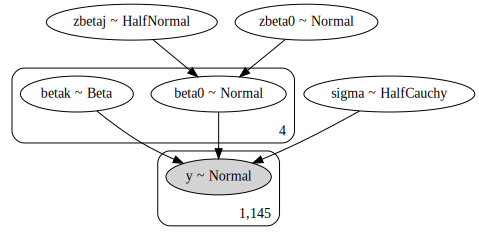

In [146]:
with Model() as hierarchical_model:
    zbeta0 = pm.Normal('zbeta0', mu=p1GDP_mean, sd=p1GDP_std)  #gdp mean and std
    zbetaj = pm.HalfNormal('zbetaj',1) #allows more possibility of high variance, on the tails

    beta0 = pm.Normal('beta0', mu=zbeta0, sigma=zbetaj, shape=length_quartile) #hyper parameters
    
    #theta =  beta0[t2] + pm.math.dot(zbeta2, zX.T) + pm.math.dot(zbetaflat, t2.T)

    
    betak = pm.Beta('betak', alpha=1, beta=1, shape=length_quartile)
    
    theta = beta0[quartile_cleaned] + betak[quartile_cleaned]*date_cleaned2

    sigma = HalfCauchy('sigma', 5)

    y = Normal('y', mu=theta, sigma=sigma, observed=zGDP2)
    
model_to_graphviz(hierarchical_model)

In [147]:
with hierarchical_model:
    hierarchical_trace = sample(10000, cores = 4,nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betak, beta0, zbetaj, zbeta0]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:53<00:00, 778.12draws/s]


(<Figure size 432x403.2 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c36718ba8>],
       dtype=object))

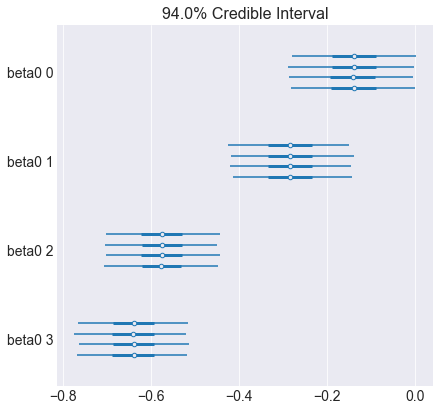

In [148]:
pm.forestplot(hierarchical_trace, var_names=['beta0'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c367226d8>,
      dtype=object)

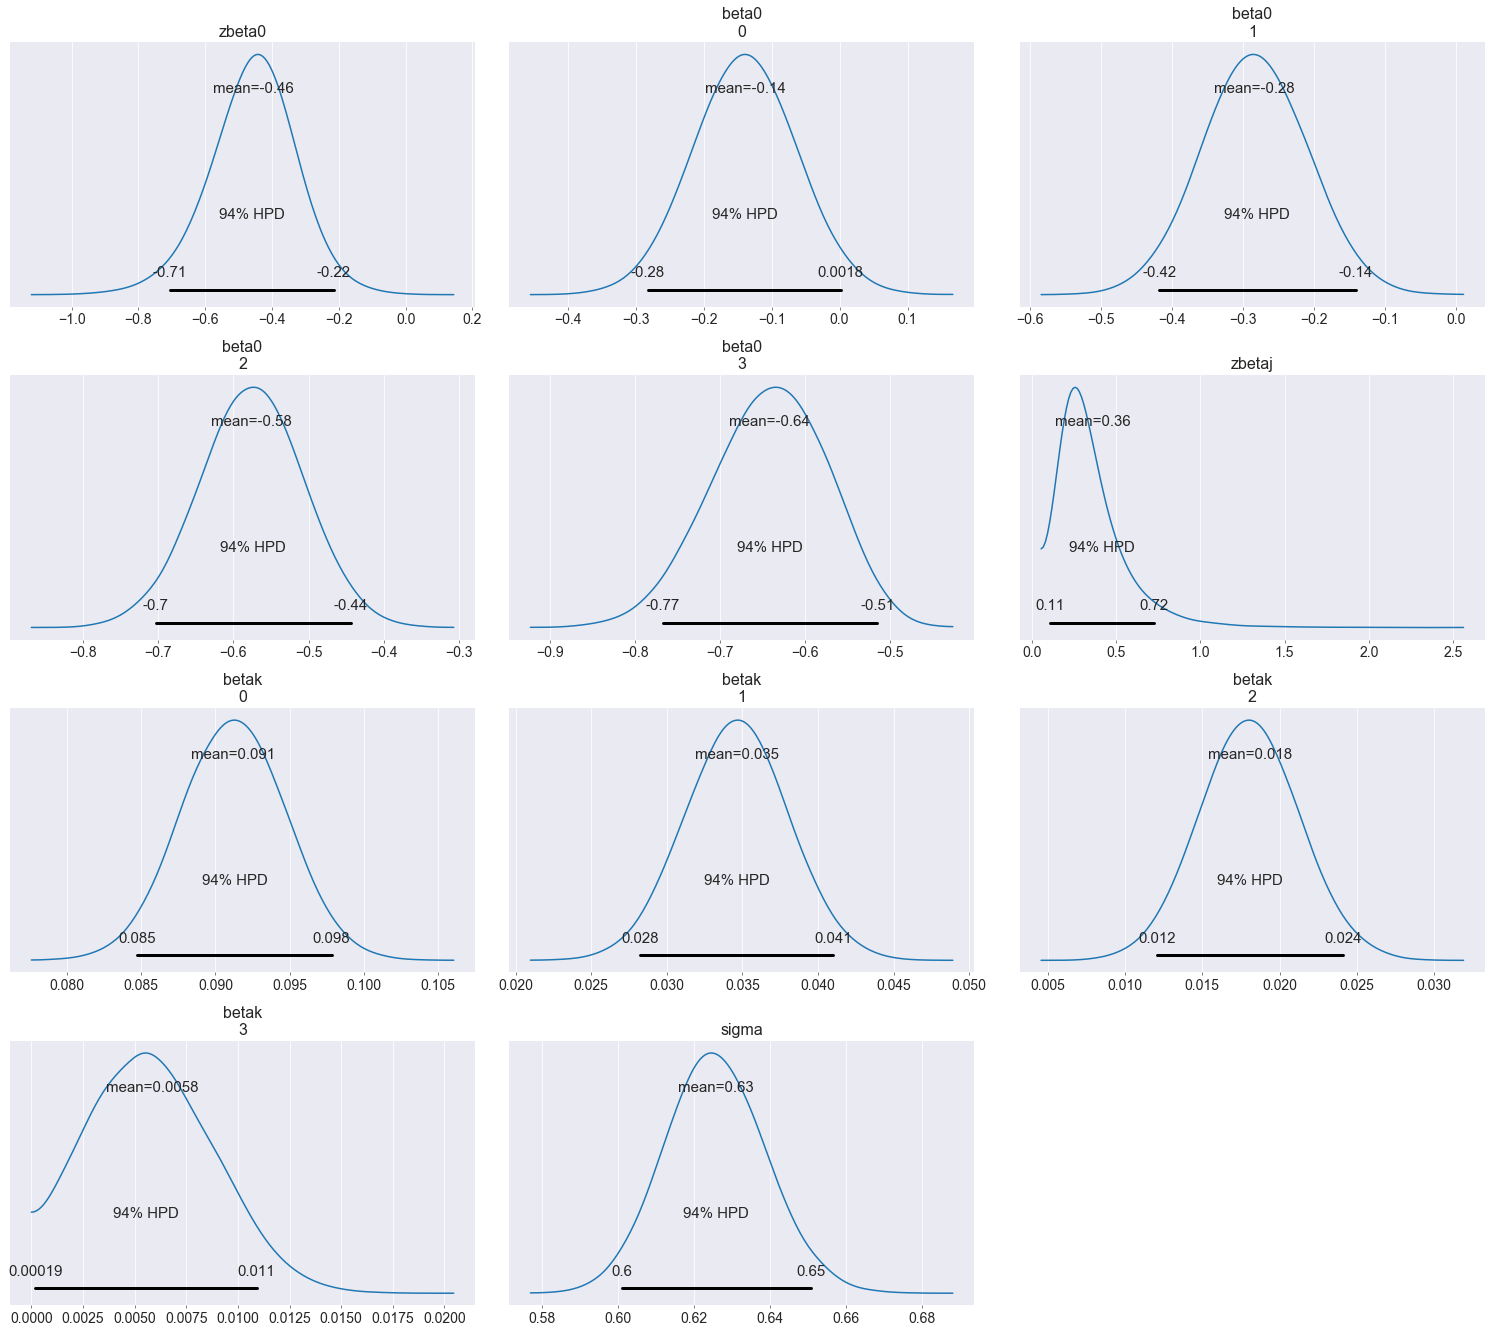

In [149]:
pm.plot_posterior(hierarchical_trace)

In [150]:
hierarchical_sum = pm.summary(hierarchical_trace)
hierarchical_sum = hierarchical_sum.drop('zbeta0', axis=0)
hierarchical_sum = hierarchical_sum.drop('zbetaj', axis=0)
hierarchical_sum

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta0__0,-0.139094,0.075472,0.000460,-2.847032e-01,0.010498,33252.728189,1.000147
beta0__1,-0.283332,0.073601,0.000458,-4.292759e-01,-0.141417,33431.983021,0.999959
beta0__2,-0.575800,0.068559,0.000327,-7.081264e-01,-0.437704,34750.587492,0.999992
beta0__3,-0.641604,0.067903,0.000414,-7.747804e-01,-0.512521,30695.739699,0.999963
betak__0,0.091221,0.003503,0.000021,8.443022e-02,0.098122,33223.255147,1.000112
betak__1,0.034625,0.003390,0.000020,2.805191e-02,0.041359,34215.834796,0.999959
betak__2,0.018060,0.003202,0.000015,1.175429e-02,0.024339,34054.482644,0.999955
betak__3,0.005846,0.003005,0.000019,2.960041e-07,0.011032,27896.764228,0.999969
sigma,0.625597,0.013171,0.000057,5.996277e-01,0.651427,47383.350114,1.000034


In [160]:
b0 = hierarchical_trace['beta0'].mean(axis=0)
bk = hierarchical_trace['betak'].mean(axis=0)

#### Hierarchical model graph 

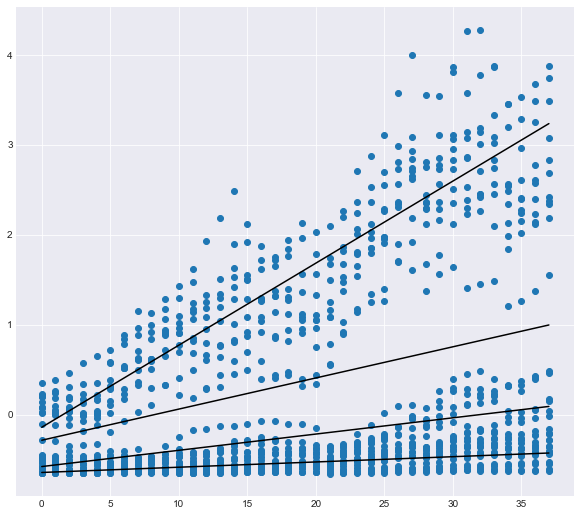

In [162]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(10, 9))



ax.scatter(date_cleaned2, zGDP2)

for i in range(length_quartile):
    plt.plot(date_cleaned2, b0[i] + bk[i]*date_cleaned2, color = 'k')

#### Hierarchical model graph with credible intervals against complete pooling

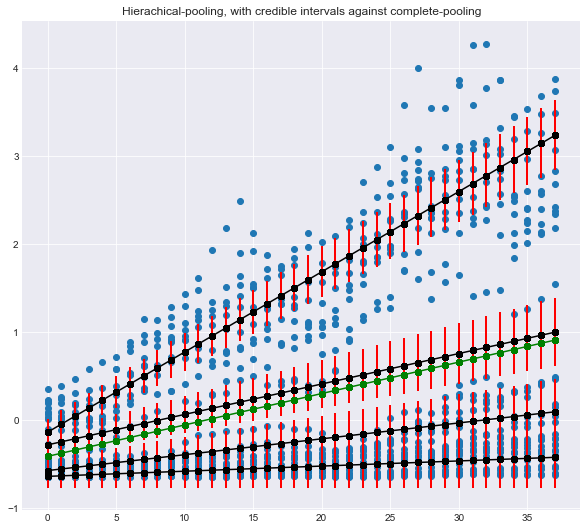

In [155]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(10, 9))

ax.scatter(date_cleaned2, zGDP2)

global_b0 = pooled_trace['beta0'].mean(axis=0)
global_bk = pooled_trace['betak'].mean(axis=0)


global_y_hat = global_b0 + global_bk*date_cleaned2
global_hpd_L = (pooled_sum.loc['beta0', 'hpd_2.5'] + 
        pooled_sum.loc['betak', 'hpd_2.5']*date_cleaned2)

global_hpd_U = (pooled_sum.loc['beta0', 'hpd_97.5'] + 
         pooled_sum.loc['betak', 'hpd_97.5']*date_cleaned2)



global_lower_error = global_y_hat - global_hpd_L
global_upper_error = global_hpd_U - global_y_hat
global_error_bar = [global_lower_error, global_upper_error]

ax.errorbar(date_cleaned2, global_y_hat, yerr=None, 
                              fmt='-o', color='g')

for i in range(length_quartile):
    

    y_hat = b0[i] + bk[i]*date_cleaned2
    hpd_L = (hierarchical_sum.iloc[i, 3] + 
             hierarchical_sum.iloc[i+4, 3]*date_cleaned2)

    hpd_U = (hierarchical_sum.iloc[i, 4] + 
             hierarchical_sum.iloc[i+4, 4]*date_cleaned2)
    lower_error = y_hat - hpd_L
    upper_error = hpd_U - y_hat
    error_bar = [lower_error, upper_error]

    ax.errorbar(date_cleaned2, y_hat, yerr=error_bar, 
            fmt='-o', ecolor='r', color='0')
    
    
    

ax.set_title('Hierachical-pooling, with credible intervals against complete-pooling')


plt.show()

#fig.savefig("Hierarchical.png",bbox_inches='tight')




## Model Comparison -- WAIC values

In [170]:
waic_pooled = az.waic(pooled_trace)
waic_pooled

Computed from 40000 by 1145 log-likelihood matrix

        Estimate       SE
IC_waic  3395.91    47.74
p_waic      2.94        -

In [171]:
waic_unpooled = az.waic(unpooled_trace)
waic_unpooled

/Users/dvisvalingam/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 40000 by 1145 log-likelihood matrix

        Estimate       SE
IC_waic  -165.33   100.71
p_waic     59.20        -

There has been a warning during the calculation. Please check the results.

In [172]:
waic_hierarchical = az.waic(hierarchical_trace)
waic_hierarchical

Computed from 40000 by 1145 log-likelihood matrix

        Estimate       SE
IC_waic  2183.29    67.04
p_waic      9.47        -